In [75]:
## IMPORT LIBRARIES

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import swifter
import pickle
import matplotlib.pyplot as plt
from functools import lru_cache
import re


In [76]:
## LOAD DATASET
df = pd.read_csv('../data/preprocessed_data.csv')
df.head()

,text,label
0,ikn ibukota koruptor nepotisme,negatif
1,sy mau tanya ikn itu untuk apa trs yg menempat...,negatif
2,bapak skolahin anak nya yg setinggi nnti bsa n...,negatif
3,wacana belim ada kesitu realnya dan faktanya a...,negatif
4,follow ig ikn pak udh dr lama kq buka lowongan...,negatif


In [77]:
## PREPROCESSING TEXT

factory = StemmerFactory()
stemmer = factory.create_stemmer()

@lru_cache(maxsize=100000)
def stem_cached(word):
    return stemmer.stem(word)

def clean_text(text: str) -> str:
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+|\@\w+|\#|[^a-zA-Z\s]', ' ', text)
    words = text.split()
    words = [stem_cached(w) for w in words]
    return ' '.join(words)

df = df.dropna(subset=['text', 'label'])
df['text_clean'] = df['text'].astype(str).swifter.apply(clean_text)
df['label'] = df['label'].swifter.apply(lambda x: x.split('/')[0])
df.head()
    

Pandas Apply: 100%|██████████| 1472/1472 [00:00<00:00, 1465119.95it/s]


,text,label,text_clean
0,ikn ibukota koruptor nepotisme,negatif,ikn ibukota koruptor nepotisme
1,sy mau tanya ikn itu untuk apa trs yg menempat...,negatif,sy mau tanya ikn itu untuk apa trs yg tempat i...
2,bapak skolahin anak nya yg setinggi nnti bsa n...,negatif,bapak skolahin anak nya yg setinggi nnti bsa n...
3,wacana belim ada kesitu realnya dan faktanya a...,negatif,wacana belim ada kesitu real dan fakta aja jan...
4,follow ig ikn pak udh dr lama kq buka lowongan...,negatif,follow ig ikn pak udh dr lama kq buka lowong t...


In [78]:
## SPLIT DATASET

X_train, X_test, y_train, y_test = train_test_split(
    df['text_clean'], df['label'], test_size=0.2, random_state=42
)

In [79]:
## VECTORIZER & TRAINING NAIVE BAYES MODEL

vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

model = MultinomialNB()
model.fit(X_train_vectorized, y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [80]:
## EVALUASI

y_pred = model.predict(X_test_vectorized)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8338983050847457
              precision    recall  f1-score   support

     negatif       0.84      0.86      0.85       159
     positif       0.83      0.80      0.82       136

    accuracy                           0.83       295
   macro avg       0.83      0.83      0.83       295
weighted avg       0.83      0.83      0.83       295



In [81]:
## UJI COBA

def predict_sentiment(text: str) -> str:
    text_clean = clean_text(text)
    vec = vectorizer.transform([text_clean])
    pred = model.predict(vec)[0]
    return pred

sample_text = "jokowi kaya anjing mukanya koruptor nepotisme mati aja!"
print(f"Text: {sample_text}\nPredicted Sentiment: {predict_sentiment(sample_text)}")

Text: jokowi kaya anjing mukanya koruptor nepotisme mati aja!
Predicted Sentiment: negatif


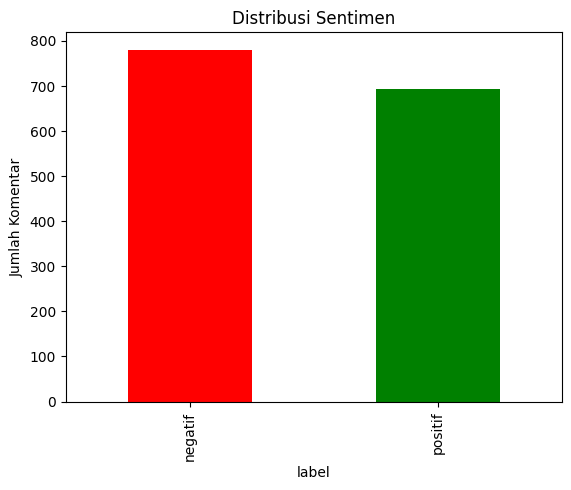

In [82]:
df['label'].value_counts().plot(kind='bar', color=['red','green','blue'])
plt.title("Distribusi Sentimen")
plt.ylabel("Jumlah Komentar")
plt.show()

In [ ]:
## SIMPAN MODEL

with open('naive_bayes_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)
    
with open('count_vectorizer.pkl', 'wb') as vec_file:
    pickle.dump(vectorizer, vec_file)
    
## TEST MODEL YANG DISIMPAN
with open('naive_bayes_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

with open('count_vectorizer.pkl', 'rb') as file:
    loaded_vectorizer = pickle.load(file)

def predict_sentiment_loaded(text):
    text_clean = clean_text(text)
    vec = loaded_vectorizer.transform([text_clean])
    pred = loaded_model.predict(vec)[0]
    return pred

predict_sentiment_loaded("ikn ibukota koruptor nepotisme")

np.str_('negatif')